## Noise Comparison Table

Run the script `noise_comparison_table.py` before running this notebook.

In [13]:
from typing import Callable, List
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

In [14]:
# anisotropic_noise_count.csv is a line-seperated list of python objects
# parse to a nested array 'data'
categories = ['Father Avg', 'Mother Avg', 'Other Avg', 'Father Max', 'Mother Max', 'Other Max']
budget_list: List[float] = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]

# pkl files are saved in './noise_comparison/anisotropic_Father Avg.pkl' etc
dfs = {}
dfs['anisotropic'] = {c: pd.read_pickle(f'./noise_comparison/anisotropic_{c}.pkl') for c in categories}
dfs['hybrid'] = {c: pd.read_pickle(f'./noise_comparison/hybrid_{c}.pkl') for c in categories}

tables = {}

for noise_type in ['anisotropic', 'hybrid']:
    tables[noise_type] = pd.DataFrame(index=budget_list, columns=categories)
    for c in categories:
        for b in budget_list:
            tables[noise_type].loc[b, c] = np.mean((dfs[noise_type][c])[dfs[noise_type][c]['mi'] == b]['noise'])

variances = {}

for noise_type in ['anisotropic', 'hybrid']:
    variances[noise_type] = pd.DataFrame(index=budget_list, columns=categories)
    for c in categories:
        for b in budget_list:
            variances[noise_type].loc[b, c] = np.mean((dfs[noise_type][c])[dfs[noise_type][c]['mi'] == b]['variances'])

means = {}

for noise_type in ['anisotropic', 'hybrid']:
    means[noise_type] = pd.DataFrame(index=budget_list, columns=categories)
    for c in categories:
        for b in budget_list:
            means[noise_type].loc[b, c] = np.mean((dfs[noise_type][c])[dfs[noise_type][c]['mi'] == b]['mean'])

tables['hybrid']

,Father Avg,Mother Avg,Other Avg,Father Max,Mother Max,Other Max
0.015625,672.301541,806.925343,1948.767164,5435.572196,14698.219174,8252.235807
0.031250,337.199132,387.145759,799.41276,2728.063262,7028.079326,4104.034853
0.062500,175.160965,164.293589,281.565533,1252.584731,3311.862164,1950.265919
0.125000,83.088943,97.928744,263.21145,677.801497,1818.745912,1000.691612
0.250000,40.225796,44.347793,64.261488,344.099065,950.289952,543.190834
0.500000,18.712919,23.191941,66.712248,162.970632,435.802605,239.576458
1.000000,8.769814,9.132847,32.977558,82.660352,219.775828,127.327467
2.000000,4.906998,5.519844,11.242984,42.321759,110.783983,63.794212
4.000000,2.453107,3.079286,15.779533,21.271456,55.385991,28.643144


In [15]:
import csv
for noise_type in ['anisotropic', 'hybrid']:
    with open(f'noise_comparison/{noise_type}_table.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerows(tables[noise_type].values)

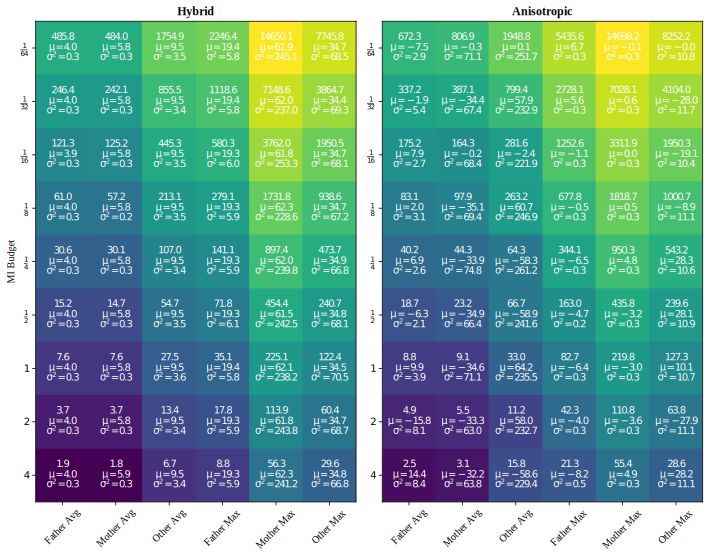

In [16]:
# plot a heatmap for anisotropic
# x axis: category
# y axis: budget

from matplotlib.colors import LogNorm

budget_list_labels = [r'$\frac{1}{val}$'.replace("val", str(int(1/val))) if val < 1 else f'${int(val)}$' for val in budget_list]

fig, axs = plt.subplots(1, 2, figsize=(10,8))

min_val, max_val = np.min([np.min(tables[noise_type].values) for noise_type in ['hybrid', 'anisotropic']]), np.max([np.max(tables[noise_type].values) for noise_type in ['hybrid', 'anisotropic']])

for noise_type in ['hybrid', 'anisotropic']:
    if noise_type == 'hybrid':
        ax = axs[0]
    elif noise_type == 'anisotropic':
        ax = axs[1]
    
    im = ax.imshow(tables[noise_type].values.astype(float), cmap='viridis', norm=LogNorm(vmax=max_val, vmin=min_val))

    ax.set_xticks(np.arange(len(categories)), categories, rotation=45)
    ax.set_yticks(np.arange(len(budget_list)), budget_list_labels)

    for i in range(len(budget_list)):
        for j in range(len(categories)):
            text = ax.text(j, i, f'${tables[noise_type].values[i, j]:.1f}$\n$\\mu={means[noise_type].values[i, j]:.1f}$\n$\\sigma^2={variances[noise_type].values[i, j]:.1f}$', ha='center', va='center', color='white')

    ax.set_title(f'{noise_type.capitalize()}')
    if noise_type == 'hybrid':
        ax.set_ylabel('MI Budget')

fig.tight_layout()

fig.savefig('figs/noise_comparison_table.png', bbox_inches='tight')

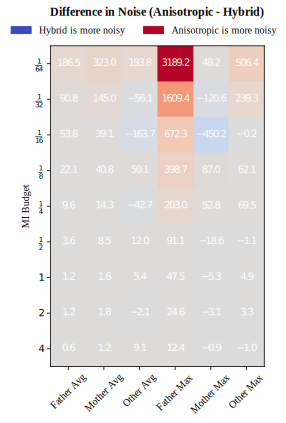

In [17]:
# Plot a heatmap that is the differences between the two noise types
budget_list_labels = [r'$\frac{1}{val}$'.replace("val", str(int(1/val))) if val < 1 else f'${int(val)}$' for val in budget_list]

fig, ax = plt.subplots(figsize=(4,6))

min_val = np.min([(tables['anisotropic'].values[i, j]) - (tables['hybrid'].values[i, j]) for i in range(len(budget_list)) for j in range(len(categories))])
max_val = np.max([(tables['anisotropic'].values[i, j]) - (tables['hybrid'].values[i, j]) for i in range(len(budget_list)) for j in range(len(categories))])
if abs(min_val) > abs(max_val):
    max_val = -min_val
else:
    min_val = -max_val

im = ax.imshow(
    (tables['anisotropic'].values.astype(float) - tables['hybrid'].values.astype(float))
    , cmap='coolwarm', vmax=max_val, vmin=min_val)

ax.set_xticks(np.arange(len(categories)), categories, rotation=45)
ax.set_yticks(np.arange(len(budget_list)), budget_list_labels)

for i in range(len(budget_list)):
    for j in range(len(categories)):
        val = (tables['anisotropic'].values[i, j]) - (tables['hybrid'].values[i, j])
        text = ax.text(j, i, f'${val:.1f}$', ha='center', va='center', color='white')

ax.set_title('Difference in Noise (Anisotropic - Hybrid)\n\n')
ax.set_ylabel('MI Budget')

# legend: red = "anisotropic is more noisy", blue = "hybrid is more noisy"
# use colors from ends of color map
import matplotlib.patches as mpatches

coolwarm_dummy = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-1, vmax=1), cmap='coolwarm')
red_patch = mpatches.Patch(color=coolwarm_dummy.to_rgba(-1), label='Hybrid is more noisy')
blue_patch = mpatches.Patch(color=coolwarm_dummy.to_rgba(1), label='Anisotropic is more noisy')
legend = fig.legend(handles=[red_patch, blue_patch], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.95), frameon=False)

fig.tight_layout()
fig.savefig('figs/noise_comparison_table_difference.png', bbox_inches='tight')

In [18]:
# Compare cumulative noise
hybrid_total = np.sum(np.sum(tables['hybrid'].values, axis=1))
anisotropic_total = np.sum(np.sum(tables['anisotropic'].values, axis=1))

print("Hybrid Total Noise (sum of variances):", hybrid_total, "Anisotropic Total Noise (sum of variances):", anisotropic_total)

Hybrid Total Noise (sum of variances): 54383.20718543179 Anisotropic Total Noise (sum of variances): 62054.36526995903
